In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))
#Pkg.add(PackageSpec(url="https://git.ligo.org/will-farr/pisnmassfunctions.jl.git"))
#Pkg.resolve()
Pkg.instantiate()

  Activating environment at `~/Projects/GW/PISN-Cali/O3a-PISN/Project.toml`


In [3]:
using Cosmology
using HDF5
using LaTeXStrings
using Statistics
using StatsBase
using StatsPlots
using Unitful
using UnitfulAstro
using O3aPISN
using PISNMassFunctions
using Plots
using Interpolations
using Turing

default(fmt=png)

Let's load up the mock observations.  We get 2D arrays of posterior samples for $m_{1,\mathrm{detector}}$, $q$, and $d_L$, as well as the log of the prior weight applied to these variables; we also get 1D arrays of the true $m_{1,\mathrm{source}}$, $q$, and $z$.

In [4]:
m1d_samps, q_samps, dl_samps, logwt_samps, m1_true, q_true, z_true, snr_obs = h5open(joinpath(@__DIR__, "../", "mocks", "observations.h5"), "r") do f
    read(f["likelihood/m1_detector"]),
    read(f["likelihood/q"]),
    read(f["likelihood/dl"]),
    read(f["likelihood/logwt"]),
    read(f["truth/m1_source"]),
    read(f["truth/q"]),
    read(f["truth/z"]),
    read(f["observed/snr_obs"])
end;

In [5]:
m1_ligo_samps, dl_ligo_samps = h5open("/Users/cosmonana/Projects/GW/blackhole-massfeature/gw_data.h5", "r") do f
    read(f["posterior_m1s"]),
    read(f["posterior_dls"])
end;


Some transformed variables:

In [6]:
m2d_samps = q_samps .* m1d_samps
mtd_samps = m1d_samps .+ m2d_samps
eta_samps = m1d_samps .* m2d_samps ./ (mtd_samps .* mtd_samps)
mcd_samps = mtd_samps .* eta_samps.^(3/5);

Each set of posterior samples is `(Nsamples, Nobservations)` broad:

In [7]:
Nsamp, Nobs = size(m1d_samps)

(1000, 3643)

The posterior samples show some structure in the $m_{1,\mathrm{detector}}$ vs $d_L$ plane:

In [8]:
h = 0.687 # km/s/Mpc/(100km/s/Mpc)
Om = 0.29
w0 = -1.0
mp0 = 40

40

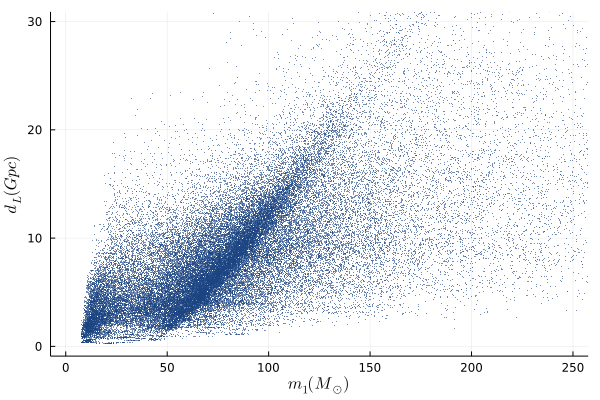

In [112]:
plotsample = scatter([m1d_samps[i,1:2000] for i in 1:30],[dl_samps[i,1:2000] for i = 1:30], ms=0.1, legend=false, xlim=[0,250], ylim=[0,30],xlabel=L"$m_1(M_{\odot})$",ylabel=L"$d_L(Gpc)$", color="#1c4481", alpha=0.6)
#savefig(plotsample,"mpeaksimsample.png")

In [38]:
function find_area(pdf_y, pdf_x, center, onesigpos)
    n = size(pdf_x)[1]
    area = sum((pdf_y[onesigpos:center-1] .+ pdf_y[onesigpos+1:center]).*(pdf_x[onesigpos+1:center] .- pdf_x[onesigpos:center-1])) / 2
    return area
end

function percent_area(pdf_y, pdf_x, center, percent=0.683)
    n = size(pdf_x)[1]
    area = sum((pdf_y[1:n-1] .+ pdf_y[2:n]).*(pdf_x[2:n] .- pdf_x[1:n-1])) / 2
    onesig = percent*area
    
    leftarea = find_area(pdf_y, pdf_x, center, 1)
    rightarea = find_area(pdf_y, pdf_x, n, center)
    
    onesigleft, onesigright = leftarea*percent, rightarea*percent
    # println(leftarea, " ", rightarea)
    # println(onesigleft, " ", onesigright)
    
    finalpos = [1, 1]
    
    right_pos, left_pos = center, 1
    mid_pos = div((right_pos+left_pos),2)
    
    while true
        areapos = find_area(pdf_y, pdf_x, center, mid_pos)
        if abs(areapos-onesigleft) <= abs(pdf_y[mid_pos]*(pdf_x[mid_pos]-pdf_x[mid_pos-1]))
            finalpos[1] = mid_pos
            break
        end

        if areapos-onesigleft > 0
            left_pos = mid_pos+1
        elseif areapos-onesigleft < 0
            right_pos = mid_pos-1
        end

        if left_pos >= right_pos
            finalpos[1] = mid_pos
            break
        end
        
        mid_pos = div((right_pos+left_pos),2)
            
    end
    
    
    right_pos, left_pos = n, center
    mid_pos = div((right_pos+left_pos),2)
    # println(mid_pos)
    while true
        areapos = find_area(pdf_y, pdf_x, mid_pos, center)
        # println("areapos ", areapos)
        # println(mid_pos," ", left_pos," ", right_pos, " ", areapos)
        # println(pdf_x[mid_pos], " ", finalpos[1]) 
        if abs(areapos-onesigright) <= abs(pdf_y[mid_pos]*(pdf_x[mid_pos]-pdf_x[mid_pos-1]))
            finalpos[2] = mid_pos
            break
        end
        
        if areapos-onesigright > 0
            right_pos = mid_pos-1
        elseif areapos-onesigright < 0
            left_pos = mid_pos+1
        end
        
        if left_pos >= right_pos
            finalpos[2] = mid_pos
            break
        end
        
        mid_pos = div((right_pos+left_pos),2)
            
    end
    return finalpos
    
end

function find_mode(pdf_y)
    return findmax(pdf_y)[2]
end

find_mode (generic function with 1 method)

In [39]:
psets = [[10, 50, 3643, 6],[30, 50, 3643, 25],[3,50,100,6]] # nbin, mbin, subNobs, maxdl
mpeakbsses = []
dlbsses = []
epochs = 2000

2000

In [40]:


mpeakbss = zeros(0)
dlbss = zeros(0)
nbin = psets[1][1]
mbin = psets[1][2]
subNobs = psets[1][3] # 3776
Nsubsamp = 1
for e = 1:epochs

    m1s_sel, dls_sel = zeros(0), zeros(0)
    n = Nsamp
    for j in 1:Nsubsamp
        idx_sel = StatsBase.sample((1:n), subNobs, replace=true)
        for k = 1:subNobs
            append!(m1s_sel, m1d_samps[idx_sel[k],k])
            append!(dls_sel, dl_samps[idx_sel[k],k])
        end
    end

    mindl, maxdl = 0, psets[1][4]
    dls_m1s = cat(dls_sel, m1s_sel, dims =(2,2))
    if mod(e,50)==0
        print(e," ")
    end

    ddl = (maxdl-mindl)/nbin
    mpeakbs = zeros(0)
    dlbs = zeros(0)

    for j = 1:nbin
        sel_m1s = zeros(0)
        sel_dls = zeros(0)
        for dm = 1:subNobs

            if dls_m1s[dm,1]<=mindl+ddl*(j+1) && dls_m1s[dm,1]>mindl+ddl*(j)
                if dls_m1s[dm,2] > 25
                    append!(sel_m1s, dls_m1s[dm,2])  
                end
                append!(sel_dls, dls_m1s[dm,1])
            end
        end
        if length(sel_m1s) == 0
            println("empty ", j)
        end
        mmin, mmax = findmin(sel_m1s)[1], findmax(sel_m1s)[1]
        dm = (mmax-mmin)/mbin
        mcount = zeros(mbin)
        for m in sel_m1s
            pos = min(mbin, convert(Int64, round((m-mmin)/dm, digits=0)+1))
            mcount[pos]+=1
        end
        #if minimum(mcount) == 0
            #println("empty mcount ", mcount)
        #end
        append!(mpeakbs, (findmax(mcount)[2]-1)*dm+mmin)
        append!(dlbs, mean(sel_dls))

    end
    #mpeak = Tuple(Float64(x) for x in mpeak)
    #mpeaks = vcat(mpeaks, mpeak)
    append!(mpeakbss, mpeakbs)
    append!(dlbss, dlbs)

end
println(size(mpeakbss))
mpeakbss = reshape(mpeakbss, (nbin, epochs))
println(size(mpeakbss))
mpeakbss10 = mpeakbss
dlbss10 = reshape(dlbss, (psets[1][1], epochs))

50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 1550 1600 1650 1700 1750 1800 1850 1900 1950 2000 (20000,)
(10, 2000)


10×2000 Matrix{Float64}:
 0.962451  0.963148  0.952139  0.951818  …  0.966244  0.943231  0.956992
 1.55643   1.52305   1.55506   1.54525      1.53576   1.5242    1.53534
 2.14388   2.12      2.10338   2.1174       2.11256   2.10849   2.13241
 2.7195    2.71501   2.71207   2.71092      2.71471   2.6986    2.7016
 3.30545   3.27108   3.27573   3.28747      3.30119   3.28296   3.30053
 3.89253   3.89674   3.9133    3.91504   …  3.90512   3.90437   3.92942
 4.47546   4.50422   4.49926   4.49805      4.46329   4.47355   4.50059
 5.08559   5.08814   5.08805   5.07588      5.08202   5.10211   5.10241
 5.70642   5.67578   5.68064   5.69829      5.70936   5.72945   5.70504
 6.30353   6.29721   6.292     6.29975      6.30244   6.30144   6.30315

In [44]:
epochs = 5000
mpeakbss = zeros(0)
dlbss = zeros(0)
nbin = psets[2][1]
mbin = psets[2][2]
subNobs = psets[2][3] # 3776
Nsubsamp = 1
for e = 1:epochs

    m1s_sel, dls_sel = zeros(0), zeros(0)
    n = Nsamp
    for j in 1:Nsubsamp
        idx_sel = StatsBase.sample((1:n), subNobs, replace=true)
        for k = 1:subNobs
            append!(m1s_sel, m1d_samps[idx_sel[k],k])
            append!(dls_sel, dl_samps[idx_sel[k],k])
        end
    end

    mindl, maxdl = 0, psets[2][4]
    dls_m1s = cat(dls_sel, m1s_sel, dims =(2,2))
    if mod(e,50)==0
        print(e," ")
    end

    ddl = (maxdl-mindl)/nbin
    mpeakbs = zeros(0)
    dlbs = zeros(0)

    for j = 1:nbin
        sel_m1s = zeros(0)
        sel_dls = zeros(0)
        for dm = 1:subNobs

            if dls_m1s[dm,1]<=mindl+ddl*(j+1) && dls_m1s[dm,1]>mindl+ddl*(j)
                if dls_m1s[dm,2] > 25
                    append!(sel_m1s, dls_m1s[dm,2])  
                end
                append!(sel_dls, dls_m1s[dm,1])
            end
        end
        if length(sel_m1s) == 0
            println("empty ", j)
        end
        mmin, mmax = findmin(sel_m1s)[1], findmax(sel_m1s)[1]
        dm = (mmax-mmin)/mbin
        mcount = zeros(mbin)
        for m in sel_m1s
            pos = min(mbin, convert(Int64, round((m-mmin)/dm, digits=0)+1))
            mcount[pos]+=1
        end
        #if minimum(mcount) == 0
            #println("empty mcount ", mcount)
        #end
        append!(mpeakbs, (findmax(mcount)[2]-1)*dm+mmin)
        append!(dlbs, mean(sel_dls))

    end
    #mpeak = Tuple(Float64(x) for x in mpeak)
    #mpeaks = vcat(mpeaks, mpeak)
    append!(mpeakbss, mpeakbs)
    append!(dlbss, dlbs)

end
println(size(mpeakbss))
mpeakbss = reshape(mpeakbss, (nbin, epochs))
println(size(mpeakbss))
mpeakbss30 = mpeakbss
dlbss30 = reshape(dlbss, (psets[2][1], epochs))

50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 1550 1600 1650 1700 1750 1800 1850 1900 1950 2000 2050 2100 2150 2200 2250 2300 2350 2400 2450 2500 2550 2600 2650 2700 2750 2800 2850 2900 2950 3000 3050 3100 3150 3200 3250 3300 3350 3400 3450 3500 3550 3600 3650 3700 3750 3800 3850 3900 3950 4000 4050 4100 4150 4200 4250 4300 4350 4400 4450 4500 4550 4600 4650 4700 4750 4800 4850 4900 4950 5000 (150000,)
(30, 5000)


30×5000 Matrix{Float64}:
  1.27314   1.27254   1.27447   1.2787   …   1.28736   1.25615   1.29106
  2.10543   2.08925   2.12224   2.09894      2.11599   2.10555   2.1195
  2.92753   2.91949   2.93942   2.92303      2.93207   2.93091   2.9356
  3.76582   3.73892   3.75434   3.78062      3.77932   3.77496   3.76232
  4.59381   4.56651   4.58641   4.57447      4.57558   4.56768   4.58662
  5.42193   5.4246    5.42      5.42458  …   5.42903   5.43276   5.409
  6.23256   6.24693   6.2512    6.25021      6.25075   6.25656   6.27021
  7.07372   7.08439   7.06849   7.10398      7.11392   7.08881   7.08124
  7.92218   7.92148   7.9207    7.93509      7.91668   7.92615   7.93901
  8.74597   8.77113   8.73422   8.7612       8.71196   8.73056   8.75972
  9.5655    9.56028   9.55998   9.58459  …   9.57483   9.57024   9.59454
 10.4226   10.4215   10.4295   10.4133      10.4298   10.3975   10.4051
 11.2737   11.2371   11.2634   11.2195      11.2505   11.2129   11.242
  ⋮                              

In [64]:
# using JSON3
# JSON3.write("mock_30nbin_50mbin_5000epochs_25samples.json",[mpeakbss30, dlbss30])
json_string = read("mock_30nbin_50mbin_5000epochs_25samples.json", String)
bss30 = JSON3.read(json_string)
mpeakbss30 = [i for i in bss30[1]]
dlbss30 = [i for i in bss30[2]]
mpeakbss30 = reshape(mpeakbss30, (30,5000))
dlbss30 = reshape(dlbss30, (30,5000))

print(" ")

In [115]:
avg_dlbs30 = mean(dlbss30,dims = 2)
avg_mpeakbs30 = mean(mpeakbss30,dims = 2)
std_mpeakbs30 = std(mpeakbss30,dims = 2)
    
plotbin = plot(avg_mpeakbs30, avg_dlbs30, xerr=std_mpeakbs30, label="Mock Mpeaks",xlabel=L"m_{1,peak}/(M_{\odot})", ylabel=L"d_L/(Gpc)", legend = false)
savefig(plotbin,"binnedm1dl.png")

In [65]:
zs = exp.(range(log(1), log(9), length=1024)) .- 1
dl = [ustrip(u"Gpc", luminosity_dist(cosmology(h=h, OmegaM=Om, w0=w0), zz)) for zz in zs]
dl_of_z = LinearInterpolation(zs, dl)
z_of_dl = LinearInterpolation(dl, zs)
print("set dl and z")

set dl and z

In [66]:
function dl_m_h0_m0(m1, m10, h0, Om=Om)
    z = m1/m10-1
    dl = ustrip(u"Gpc", luminosity_dist(cosmology(h=h0, OmegaM=Om, w0=w0), z))
    return dl
end

function m_dl_h0_m0(m1, dl, h0, Om, w0)
    
    zs = exp.(range(log(1), log(9), length=1024)) .- 1
    dls = [ustrip(u"Gpc", luminosity_dist(cosmology(h=h0, OmegaM=Om, w0=w0), zz)) for zz in zs]
    dl_of_z = LinearInterpolation(zs, dls)
    z_of_dl = LinearInterpolation(dls, zs)

    z = z_of_dl(dl)
    m1n = m1*(1+z)
    return m1n
end

function dls_m_h0_m0(m1, m10, h0, Om, w0=-1.0)
    zs = m1./m10 .- 1
    dls = [ustrip(u"Gpc", luminosity_dist(cosmology(h=h0, OmegaM=Om, w0=w0), z)) for z in zs]
    return vec(dls)
end

dls_m_h0_m0 (generic function with 2 methods)

In [67]:
#Pkg.add("LsqFit")
#using LsqFit

In [68]:
@. model(x, p) = dl_m_h0_m0(x, p[1], p[2], p[3])

model (generic function with 1 method)

In [91]:
@model function mass_vs_distance(mu_m, sigma_m, d, zbase)
    h ~ Uniform(0.7, 2.0) #truncated(Normal(0.732, 0.013), 0, 2) #Uniform(0.38, 2)
    #ΩM ~ Uniform(0, 1)
    ΩMh ~ truncated(Normal(0.1424, 0.03), 0, 0.3)
    m_p ~ truncated(Normal(40, 2), 0, Inf)
    
    #h = sqrt(hz^2 + ΩMh - ΩMh * (1+zbase)^3)
    ΩM = ΩMh/h^2
    zs = expm1.(log(1.0):0.01:log(1.0+10.0))
    dH_ = PISNMassFunctions.dH(h)
    dCs = PISNMassFunctions.dCs(zs, ΩM, -1)
    dLs = PISNMassFunctions.dLs(zs, dCs)
    
    z_of_d = PISNMassFunctions.interp(dLs .* dH_, zs)
    
    #JhΩM = ΩM*h^2*(ΩM*(1+0.2)^3+1-ΩM)^(-0.5)((1+0.2)^3-1)-h^2*(ΩM*(1+0.2)^3+1-ΩM)^0.5

    m_peak_predicted = m_p .* (1 .+ z_of_d.(d))
    mu_m ~ MvNormal(m_peak_predicted, sigma_m)
    return mu_m=mu_m, m_p_det=m_peak_predicted
end

mass_vs_distance (generic function with 1 method)

In [92]:
chains_30_z0 = mapreduce(c -> sample(mass_vs_distance(avg_mpeakbs30[1:nbin], std_mpeakbs30[1:nbin], avg_dlbs30[1:nbin],0), NUTS(), 2000), chainscat, 1:3)

┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/cosmonana/.julia/packages/Turing/y0DW3/src/inference/hmc.jl:188
Sampling:   4%|█▍                                       |  ETA: 0:04:16┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/cosmonana/.julia/packages/AdvancedHMC/yd6UP/src/hamiltonian.jl:47
Sampling:   6%|██▌                                      |  ETA: 0:02:47┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/cosmonana/.julia/packages/AdvancedHMC/yd6UP/src/hamiltonian.jl:47
Sampling:  12%|█████▏                                   |  ETA: 0:01:40┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/cosmonana/.julia/packages/AdvancedHMC/

Chains MCMC chain (2000×15×3 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 3
Samples per chain = 2000
Wall duration     = 190.51 seconds
Compute duration  = 190.08 seconds
parameters        = h, m_p, ΩMh
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           h    0.7830    0.0730     0.0009    0.0037    279.8196    1.0262    ⋯
         ΩMh    0.1387    0.0232     0.0003    0.0006   1422.3583    1.0007    ⋯
         m_p   36.1459    1.0172     0.0131    0.0463    381.1323    1.0164    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     

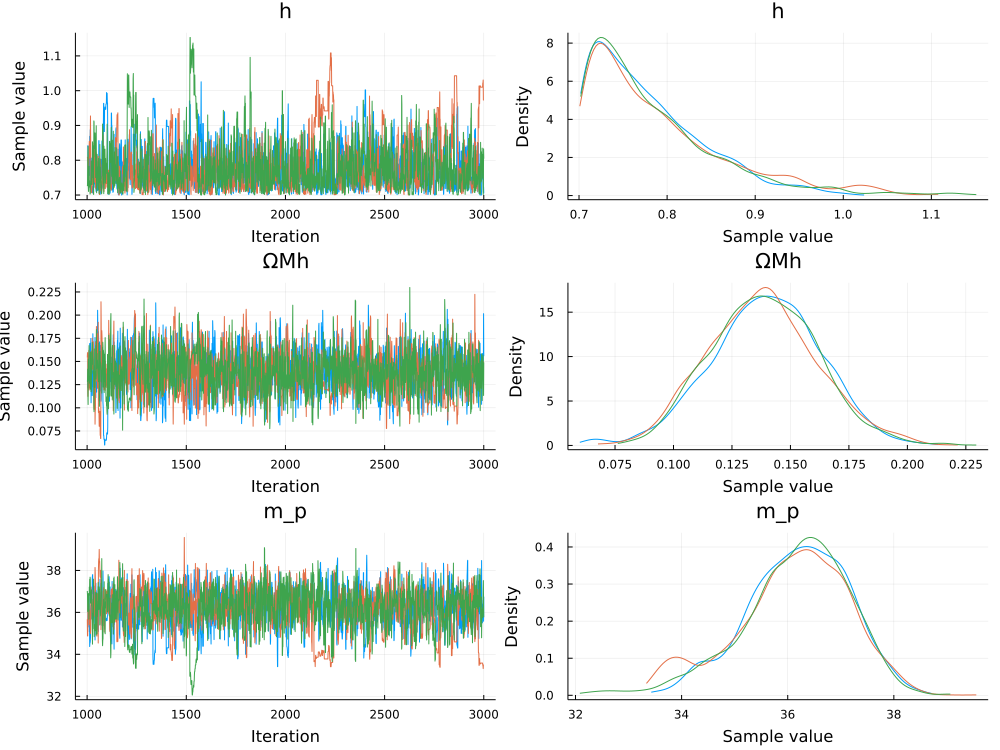

In [93]:
plot(chains_30_z0)

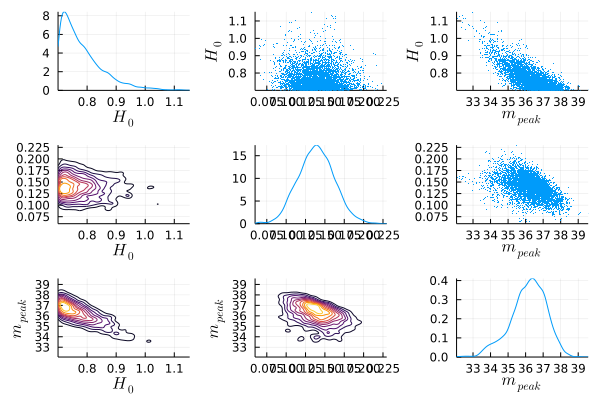

ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error


In [95]:
@df chains_30_z0 O3aPISN.cornerdensity((:h, :ΩMh, :m_p), labels=(L"H_0", L"ΩMh", L"m_{peak}"))

(126, 3000)

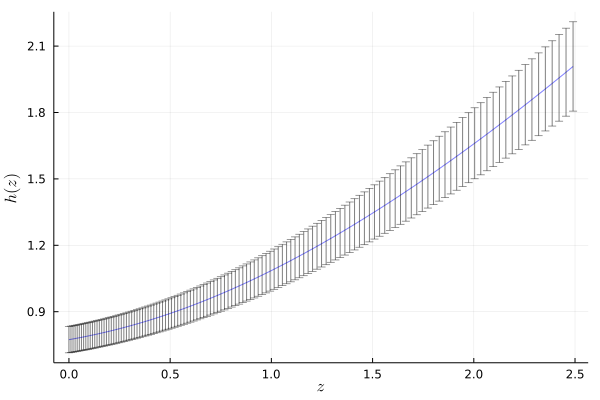

In [97]:
# nbin = 30

zs = expm1.(log(1.0):0.01:log(1.0+2.5))
hzs = zeros(0)
nzbin = size(zs)[1]
h_planck = chains_30_z0[:h]
ΩM_planck = chains_30_z0[:ΩMh]
mp_planck = chains_30_z0[:m_p]
    
nsamples = 3000
for i = 1:nsamples
    hz = h_planck[i] .* sqrt.(ΩM_planck[i].*(1 .+ zs).^3 .+ 1 .- ΩM_planck[i])
    append!(hzs, hz)

end
hzs = reshape(hzs, (nzbin, nsamples))
print(size(hzs))

# plot(zs, hzs[:,1], xlabel=L"z", ylabel=L"h(z)",alpha=0.05, color="blue", legend = false)
# for i = 2:nsamples
#     plot!(zs, hzs[:,i], xlabel=L"z", ylabel=L"h(z)",alpha=0.05, color="blue", legend = false)
# end
hzavr = [mean(hzs[i,:]) for i in 1:nzbin]
hzstd = [std(hzs[i,:]) for i in 1:nzbin]
plot(zs, hzavr, yerr=hzstd, xlabel=L"z", ylabel=L"h(z)",alpha=0.5, color="blue", legend = false)

In [160]:
@model function mass_vs_distance_free(mu_m, sigma_m, d, zbase)
    h ~ Uniform(0.4, 1.4) #truncated(Normal(0.732, 0.013), 0, 2) #Uniform(0.38, 2)
    ΩM ~ Uniform(0, 1)
    #ΩMh ~ Uniform(0, 1) #truncated(Normal(0.1424, 0.03), 0, 0.3)
    m_p ~ truncated(Normal(40,15), 0, Inf)
    
    #h = sqrt(hz^2 + ΩMh - ΩMh * (1+zbase)^3)
    #ΩM = ΩMh/h^2
    zs = expm1.(log(1.0):0.01:log(1.0+10.0))
    dH_ = PISNMassFunctions.dH(h)
    dCs = PISNMassFunctions.dCs(zs, ΩM, -1)
    dLs = PISNMassFunctions.dLs(zs, dCs)
    
    z_of_d = PISNMassFunctions.interp(dLs .* dH_, zs)
    
    #JhΩM = ΩM*h^2*(ΩM*(1+0.2)^3+1-ΩM)^(-0.5)((1+0.2)^3-1)-h^2*(ΩM*(1+0.2)^3+1-ΩM)^0.5

    m_peak_predicted = m_p .* (1 .+ z_of_d.(d))
    mu_m ~ MvNormal(m_peak_predicted, sigma_m)
    return mu_m=mu_m, m_p_det=m_peak_predicted
end

mass_vs_distance_free (generic function with 1 method)

In [161]:
chains_free_30_z0 = mapreduce(c -> sample(mass_vs_distance_free(avg_mpeakbs30[1:nbin], std_mpeakbs30[1:nbin], avg_dlbs30[1:nbin],0), NUTS(), 2000), chainscat, 1:3)

┌ Info: Found initial step size
│   ϵ = 0.0054687500000000005
└ @ Turing.Inference /Users/cosmonana/.julia/packages/Turing/y0DW3/src/inference/hmc.jl:188
Sampling:   4%|█▍                                       |  ETA: 0:09:50┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/cosmonana/.julia/packages/AdvancedHMC/yd6UP/src/hamiltonian.jl:47
Sampling:   6%|██▎                                      |  ETA: 0:07:10┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/cosmonana/.julia/packages/AdvancedHMC/yd6UP/src/hamiltonian.jl:47
Sampling:   6%|██▌                                      |  ETA: 0:06:43┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/cosmonana/.julia/package

Chains MCMC chain (2000×15×3 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 3
Samples per chain = 2000
Wall duration     = 548.9 seconds
Compute duration  = 547.94 seconds
parameters        = h, ΩM, m_p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           h    0.7616    0.2483     0.0032    0.0076   1069.2772    1.0052    ⋯
          ΩM    0.4146    0.2580     0.0033    0.0074   1095.4559    1.0051    ⋯
         m_p   35.7886    3.0069     0.0388    0.0847   1194.3156    1.0038    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75

In [154]:
#write("mbinfit_free_30_h0_Om_m1peaknarrow.jls", chains_free_30_z0)

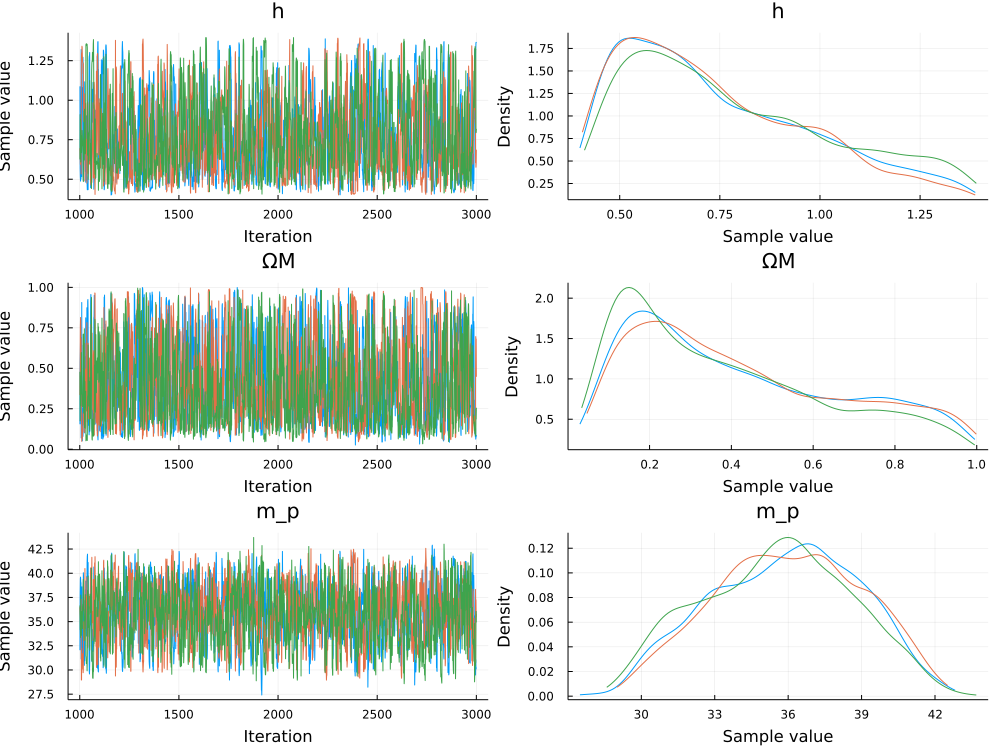

In [162]:
plot(chains_free_30_z0)

In [163]:
plotd = @df chains_free_30_z0 O3aPISN.cornerdensity((:h, :ΩM, :m_p), labels=(L"h_0", L"\Omega_M", L"m_{1,peak}(M_{\odot})"))
plot!(size=(800,800))
#savefig(plotd,"binfreefitpost.png")

(126, 3000)

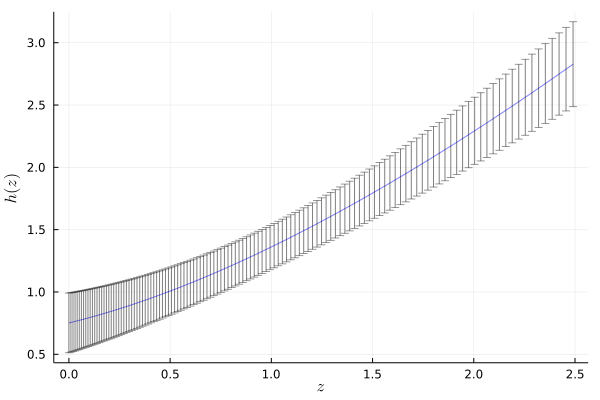

In [164]:
# nbin = 30

zs = expm1.(log(1.0):0.01:log(1.0+2.5))
hzs = zeros(0)
nzbin = size(zs)[1]
h_planck = chains_free_30_z0[:h]
ΩM_planck = chains_free_30_z0[:ΩM]
mp_planck = chains_free_30_z0[:m_p]
    
nsamples = 3000
for i = 1:nsamples
    hz = h_planck[i] .* sqrt.(ΩM_planck[i].*(1 .+ zs).^3 .+ 1 .- ΩM_planck[i])
    append!(hzs, hz)

end
hzs = reshape(hzs, (nzbin, nsamples))
print(size(hzs))

# plot(zs, hzs[:,1], xlabel=L"z", ylabel=L"h(z)",alpha=0.05, color="blue", legend = false)
# for i = 2:nsamples
#     plot!(zs, hzs[:,i], xlabel=L"z", ylabel=L"h(z)",alpha=0.05, color="blue", legend = false)
# end
hzavr = [mean(hzs[i,:]) for i in 1:nzbin]
hzstd = [std(hzs[i,:]) for i in 1:nzbin]
plot(zs, hzavr, yerr=hzstd, xlabel=L"z", ylabel=L"h(z)",alpha=0.5, color="blue", legend = false)

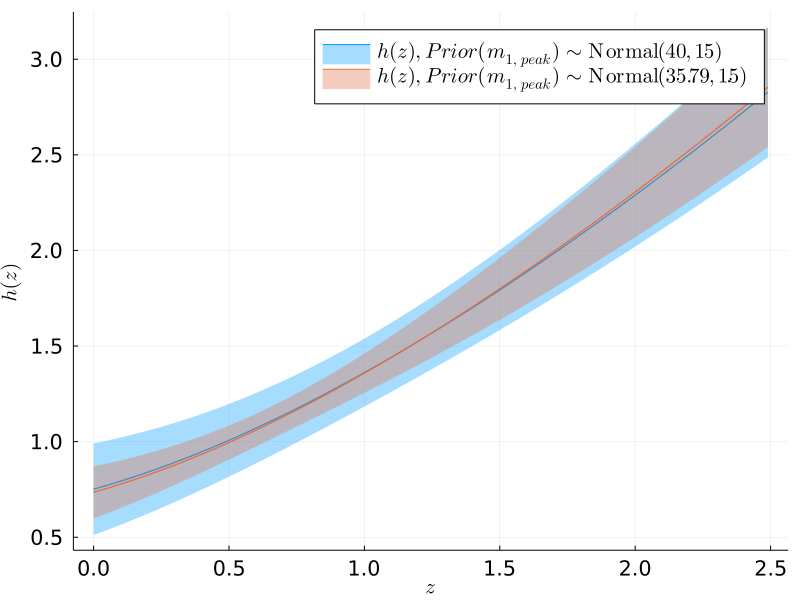

In [183]:
#hzavrnarrow = [mean(hzs[i,:]) for i in 1:nzbin]
#hzstdnarrow = [std(hzs[i,:]) for i in 1:nzbin]
#plot(zs, hzavr, xlabel=L"z", ylabel=L"h(z)",alpha=0.5, color="blue", legend = false)
plotf = plot(zs, hzavr, fillrange = hzavr.+hzstd, fillalpha = 0.35, c = 1, label = L"h(z), Prior(m_{1,peak})\sim \mathrm{Normal}(40,15)")
plot!(zs, hzavr, fillrange = hzavr.-hzstd, fillalpha = 0.35, c = 1,label = "")
#plot!(zs, hzavrnarrow, xlabel=L"z", ylabel=L"h(z)",alpha=0.5, color="orange", legend = false)
plot!(zs, hzavrnarrow, fillrange = hzavrnarrow.+hzstdnarrow, fillalpha = 0.35, c = 2, label = L"h(z), Prior(m_{1,peak})\sim \mathrm{Normal}(35.79,1.5)")
plot!(zs, hzavrnarrow, fillrange = hzavrnarrow.-hzstdnarrow, fillalpha = 0.35, c = 2, xlabel=L"z", ylabel=L"h(z)", label = "", legend = true)
plot!(size=(800,600),xtickfont=font(14), 
    ytickfont=font(14), 
    guidefont=font(14), 
    legendfont=font(14))
#savefig(plotf,"binfithz.png")

In [184]:
print(findmin(hzstdnarrow)," ", findmin(hzstd)," ",zs[51]," ",zs[64]," ", hzavr[51]," ",hzavr[64])

(0.08538970951226081, 51) (0.17639545207782148, 64) 0.6487212707001282 0.8776105792643432 1.1031497798598473 1.2666442405449683